In [1]:
#Core Libraries
import os
import glob
import numpy as np
import pickle
from sklearn.decomposition import PCA

#Visualization
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation
from IPython.display import HTML

#PyTorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau

#Utilities
from tqdm import tqdm
from tqdm import trange
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import IncrementalPCA
from transformers import get_cosine_schedule_with_warmup
from torch.optim import Adam
import torch.nn.utils as nn_utils

In [2]:
# load deepspeech audio features and index mapping
with open('/home/s5722127/MasterClass/traineddata/processed_audio_deepspeech.pkl', 'rb') as af:
    deepspeech_data = pickle.load(af, encoding='latin1')

with open('/home/s5722127/MasterClass/traineddata/subj_seq_to_idx.pkl', 'rb') as sf:
    index_map = pickle.load(sf, encoding='latin1')

with open('/home/s5722127/MasterClass/traineddata/templates.pkl', 'rb') as f:
    templates = pickle.load(f, encoding='latin1')

# show loaded subject names
if isinstance(deepspeech_data, dict):
    print("subjects:", list(deepspeech_data.keys()))


vertex_sequences = np.load('/home/s5722127/MasterClass/traineddata/data_verts.npy')

subjects: ['FaceTalk_170904_00128_TA', 'FaceTalk_170811_03275_TA', 'FaceTalk_170725_00137_TA', 'FaceTalk_170811_03274_TA', 'FaceTalk_170915_00223_TA', 'FaceTalk_170912_03278_TA', 'FaceTalk_170809_00138_TA', 'FaceTalk_170908_03277_TA', 'FaceTalk_170728_03272_TA', 'FaceTalk_170913_03279_TA', 'FaceTalk_170731_00024_TA', 'FaceTalk_170904_03276_TA']


In [ ]:
# Initialize empty lists to store paired data
audio_samples = []
expression_targets = []
sequence_labels = []

# Iterate over each subject in the index map
for subject_id in index_map.keys():
    subject_audio = deepspeech_data.get(subject_id)
    if subject_audio is None:
        continue

    subject_sequences = index_map[subject_id]

    # Iterate over each sentence for the current subject
    for sentence_id in subject_sequences.keys():
        sentence_audio = subject_audio.get(sentence_id)
        if sentence_audio is None:
            continue

        # Safely get the frame mapping and generate ordered indices
        frame_map = subject_sequences[sentence_id]
        ordered_indices = []
        for frame_key in sorted(frame_map):
            ordered_indices.append(frame_map[frame_key])

        # Retrieve mesh expression frames and audio features
        try:
            expr_seq = vertex_sequences[ordered_indices]
            audio_seq = sentence_audio['audio']
        except Exception as e:
            print(f"Skipping {subject_id}_{sentence_id} due to error: {e}")
            continue

        # Align both sequences to the same length
        sequence_length = min(len(expr_seq), len(audio_seq))
        expr_seq = expr_seq[:sequence_length]
        audio_seq = audio_seq[:sequence_length]

        # Compute mesh offset from template
        offset_seq = expr_seq - templates[subject_id][None, :]

        # Store the aligned data
        audio_samples.append(audio_seq)
        expression_targets.append(offset_seq)
        sequence_labels.append(f"{subject_id}_{sentence_id}")

# Display summary information
print(f"Total aligned sequences: {len(audio_samples)}")
print(f"Sample shapes: {audio_samples[0].shape}, {expression_targets[0].shape}, ID: {sequence_labels[0]}")

Total aligned sequences: 473
Sample shapes: (203, 16, 29), (203, 5023, 3), ID: FaceTalk_170904_00128_TA_sentence37


In [ ]:
# === Step 1: Normalize expression_targets with StandardScaler ===

expr_scaler = StandardScaler()
for seq in expression_targets:
    flattened = seq.reshape(-1, 5023 * 3)
    expr_scaler.partial_fit(flattened)


# === Step 2: Setup PCA with Streaming Fit ===

n_dim = 1000
ipca = IncrementalPCA(n_components=n_dim)

def generate_pca_chunks(sequences, scaler, chunk_size):
    buffer = []
    current_size = 0

    for seq in sequences:
        norm_seq = scaler.transform(seq.reshape(-1, 5023 * 3))
        buffer.append(norm_seq)
        current_size += norm_seq.shape[0]

        if current_size >= chunk_size:
            yield np.concatenate(buffer, axis=0)[:chunk_size]
            buffer.clear()
            current_size = 0

    if buffer:
        yield np.concatenate(buffer, axis=0)

for chunk in generate_pca_chunks(expression_targets, expr_scaler, n_dim):
    ipca.partial_fit(chunk)


# === Step 3: Find number of components that retain variance ===

explained = np.cumsum(ipca.explained_variance_ratio_)
num_components = next(i + 1 for i, val in enumerate(explained) if val >= 0.99)


# === Step 4: Reduce all sequences using PCA ===

pca_expressions = [
    ipca.transform(expr_scaler.transform(seq.reshape(-1, 5023 * 3)))[:, :num_components]
    for seq in expression_targets
]


# === Step 5: Save PCA parameters for future use ===

pca_basis = ipca.components_[:num_components]
pca_mean = ipca.mean_
pca_var_ratio = ipca.explained_variance_ratio_[:num_components]

In [ ]:
# === Combine and Normalize PCA-Projected Expression Data ===

# Concatenate all PCA-projected expression sequences into one large array
expr_pca = np.vstack(pca_expressions)  # shape: (total_frames, num_components)

# Calculate global mean and std for second-stage normalization
expr_pca_mean = np.mean(expr_pca, axis=0)
expr_pca_std = np.std(expr_pca, axis=0) + 1e-5  # avoid division by zero

# Normalize each PCA sequence using global stats
normalized_pca_expr = [(seq - expr_pca_mean) / expr_pca_std for seq in pca_expressions]

# === Normalize audio (must be done before this block) ===
flat_audio = np.concatenate(audio_samples, axis=0).reshape(-1, 464)
audio_mu = flat_audio.mean(axis=0)
audio_sigma = flat_audio.std(axis=0) + 1e-5
norm_audio = [(seq.reshape(seq.shape[0], -1) - audio_mu) / audio_sigma for seq in audio_samples]

# === Save Processed Data to Dictionary ===

out = dict(
    audio=norm_audio,
    expression=normalized_pca_expr,
    audio_mean=audio_mu,
    audio_std=audio_sigma,
    expression_mean=expr_scaler.mean_,
    expression_std=(expr_scaler.var_ ** 0.5) + 1e-5,
    pca_components=pca_basis,
    pca_internal_mean=pca_mean,
    explained_ratio=pca_var_ratio,
    pca_mean=expr_pca_mean,
    pca_std=expr_pca_std,
    sequence_labels=sequence_labels
)

# Save to disk
output_path = 'processed_data.pkl'
with open(output_path, 'wb') as f:
    pickle.dump(out, f)


In [ ]:
with open('processed_data.pkl', 'rb') as f:
    data = pickle.load(f)

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

# === Custom Dataset for Sliding Window Lip Sync Sequences ===
class LipSyncWindowDataset(Dataset):
    def __init__(self, audio_sequences, expression_sequences, win_size=30, step=2):
        self.data_pairs = []

        # Generate paired audio-expression windows with sliding approach
        for audio_seq, expr_seq in zip(audio_sequences, expression_sequences):
            max_index = min(len(audio_seq), len(expr_seq)) - win_size + 1
            if max_index < 1:
                continue  # skip sequences too short for one window

            window_starts = range(0, max_index, step)

            for start in window_starts:
                end = start + win_size
                mel_segment = torch.tensor(audio_seq[start:end], dtype=torch.float32)
                expr_segment = torch.tensor(expr_seq[start:end], dtype=torch.float32)
                self.data_pairs.append((mel_segment, expr_segment))

    def __len__(self):
        return len(self.data_pairs)

    def __getitem__(self, idx):
        return self.data_pairs[idx]


# === Split Dataset Into Train, Validation, and Test Sets ===

# First: 80% train, 20% temp (for val + test)
train_audio, temp_audio, train_expr, temp_expr = train_test_split(
    data['audio'], data['expression'], test_size=0.2, random_state=42
)

# Then: split temp evenly into validation and test sets
val_audio, test_audio, val_expr, test_expr = train_test_split(
    temp_audio, temp_expr, test_size=0.5, random_state=42
)


# === Create Dataset Objects with Windowing Parameters ===

train_dataset = LipSyncWindowDataset(train_audio, train_expr, win_size=30, step=2)
val_dataset   = LipSyncWindowDataset(val_audio, val_expr, win_size=30, step=2)
test_dataset  = LipSyncWindowDataset(test_audio, test_expr, win_size=30, step=2)


# === Wrap in DataLoaders ===

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)


# === Report Dataset Sizes ===

print(f"train={len(train_dataset)}, val={len(val_dataset)}, test={len(test_dataset)}")

train=42761, val=5802, test=5693


In [ ]:
class AudioToExpressionTransformer(nn.Module):
    def __init__(self, 
                 input_dim=464,
                 output_dim=284,
                 hidden_dim=512,
                 num_heads=8,
                 num_layers=2,
                 dropout=0.5,
                 max_seq_len=30):
        super().__init__()

        # linear projection for input features
        self.input_proj = nn.Linear(input_dim, hidden_dim)
        self.dropout_in = nn.Dropout(dropout)

        # learnable positional encoding
        self.positional_embedding = nn.Parameter(
            torch.randn(1, max_seq_len, hidden_dim)
        )

        # normalization before transformer
        self.norm = nn.LayerNorm(hidden_dim)

        # transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_dim,
            nhead=num_heads,
            dim_feedforward=hidden_dim,
            dropout=dropout,
            batch_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # final projection to expression space with extra non-linearity
        self.output_head = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, output_dim),
            nn.LayerNorm(output_dim)
        )

    def forward(self, mel_input):
        # handle both [B, T, 16, 29] and [B, T, 464] input formats
        if mel_input.ndim == 4:
            B, T, C, F = mel_input.shape
            mel_input = mel_input.view(B, T, C * F)
        elif mel_input.ndim != 3:
            raise ValueError(f"expected 3D or 4D tensor, got {mel_input.shape}")

        B, T, _ = mel_input.shape

        x = self.input_proj(mel_input)
        x = self.dropout_in(x)
        x = x + self.positional_embedding[:, :T, :]
        x = self.norm(x)

        encoded = self.encoder(x)
        x = x + encoded  # residual connection

        return self.output_head(x)


[100/100] train: 0.9372 | val: 0.9557: 100%|██████████| 100/100 [06:46<00:00,  4.07s/it]


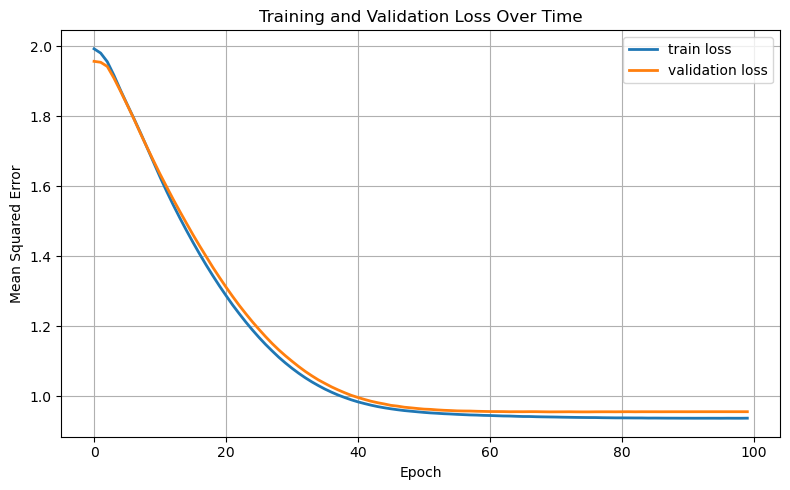

In [ ]:
# === Setup Device and Model ===

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = AudioToExpressionTransformer(max_seq_len=30).to(device)


# === Optimizer and Learning Rate Scheduler ===

optimizer = Adam(model.parameters(), lr=1e-5, weight_decay=1e-4)

num_epochs = 100
total_steps = num_epochs * len(train_loader)

scheduler = get_cosine_schedule_with_warmup(
    optimizer,
    num_warmup_steps=int(0.1 * total_steps),
    num_training_steps=total_steps
)


# === Training Loop with Early Stopping ===

train_losses = []
val_losses = []
best_val = float('inf')
wait = 0
patience = 30

progress_bar = trange(num_epochs, desc="training", leave=True)

for epoch in progress_bar:
    # ---- Training Phase ----
    model.train()
    epoch_train_loss = 0.0

    for mel_batch, expr_batch in train_loader:
        mel_batch = mel_batch.to(device)
        expr_batch = expr_batch.to(device)

        optimizer.zero_grad()
        output = model(mel_batch)

        loss = torch.mean((output - expr_batch) ** 2)
        loss.backward()

        nn_utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()

        epoch_train_loss += loss.item()

    avg_train_loss = epoch_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)


    # ---- Validation Phase ----
    model.eval()
    epoch_val_loss = 0.0

    with torch.no_grad():
        for mel_batch, expr_batch in val_loader:
            mel_batch = mel_batch.to(device)
            expr_batch = expr_batch.to(device)

            predictions = model(mel_batch)
            loss = torch.mean((predictions - expr_batch) ** 2)
            epoch_val_loss += loss.item()

    avg_val_loss = epoch_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)


    # ---- Progress and Early Stopping ----
    progress_bar.set_description(
        f"[{epoch + 1}/{num_epochs}] train: {avg_train_loss:.4f} | val: {avg_val_loss:.4f}"
    )

    if avg_val_loss < best_val:
        best_val = avg_val_loss
        wait = 0
        torch.save(model.state_dict(), 'best_model.pt')
    else:
        wait += 1
        if wait >= patience:
            progress_bar.write(
                f"Early stopping triggered at epoch {epoch+1}: no improvement for {patience} epochs"
            )
            break


# === Visualize Training History ===

plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="train loss", linewidth=2)
plt.plot(val_losses, label="validation loss", linewidth=2)
plt.xlabel("Epoch")
plt.ylabel("Mean Squared Error")
plt.title("Training and Validation Loss Over Time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# === Load Pretrained Model from Checkpoint ===

model = AudioToExpressionTransformer(max_seq_len=30)
checkpoint = torch.load('best_model.pt', weights_only=True)
model.load_state_dict(checkpoint)
model.eval()


# === Define Evaluation Function for a Single Batch ===

def evaluate(model, loader, device='cuda'):
    model.to(device)
    model.eval()

    # Fetch the first available batch from the loader
    try:
        mel_input, expr_target = next(iter(loader))
    except StopIteration:
        raise ValueError("Test loader is empty.")

    mel_input = mel_input.to(device)
    expr_target = expr_target.to(device)

    with torch.no_grad():
        prediction = model(mel_input)

    return prediction.cpu(), expr_target.cpu()


# === Run Evaluation on a Test Batch ===

pred_batch, gt_batch = evaluate(model, test_loader)

In [ ]:
# === Extract PCA-Normalized Outputs ===

# Convert tensors to NumPy arrays
predicted_pca = pred_batch[0].cpu().numpy()
groundtruth_pca = gt_batch[0].cpu().numpy()


# === Load Preprocessing Parameters from File ===

with open("processed_data.pkl", "rb") as f:
    params = pickle.load(f)

# Extract required normalization and PCA parameters
expr_mean           = params['expression_mean']
expr_std            = params['expression_std']
pca_basis           = params['pca_components']
pca_internal_mean   = params['pca_internal_mean']
pca_mean            = params['pca_mean']
pca_std             = params['pca_std']


# === Define Function to Reconstruct Mesh from Normalized PCA ===

def inverse_normalize_pca(normalized_pca):
    # Step 1: Undo z-score normalization applied after PCA
    denorm_pca = (normalized_pca * pca_std) + pca_mean

    # Step 2: Reverse PCA projection (project back into high-dimensional space)
    pca_projected = np.dot(denorm_pca, pca_basis)
    full_flat = pca_projected + pca_internal_mean

    # Step 3: Undo original expression normalization (std/mean)
    original_flat = (full_flat * expr_std) + expr_mean

    # Step 4: Reshape into original 3D mesh format
    return original_flat.reshape(-1, 5023, 3)


# === Recover Mesh Sequences from PCA Representation ===

predicted_expr = inverse_normalize_pca(predicted_pca)
groundtruth_expr = inverse_normalize_pca(groundtruth_pca)

print(predicted_expr.shape, groundtruth_expr.shape)

# add template mesh back to offsets to get full mesh vertices
predicted_mesh = predicted_expr * 1.5 + templates['FaceTalk_170809_00138_TA']
groundtruth_mesh = groundtruth_expr + templates['FaceTalk_170809_00138_TA']

(30, 5023, 3) (30, 5023, 3)


In [ ]:
def overlay_mesh_comparison(pred_seq, gt_seq, frame_idx=0, zoom=1.0, elev=-90, azim=90, size=0.5):
    
    # Get frame
    pred = pred_seq[frame_idx] * zoom
    gt   = gt_seq[frame_idx] * zoom

    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')

    # Ground truth in blue
    ax.scatter(gt[:, 0], gt[:, 1], gt[:, 2], s=size, c='blue', label='Ground Truth')

    # Prediction in red
    ax.scatter(pred[:, 0], pred[:, 1], pred[:, 2], s=size, c='red', alpha=0.6, label='Prediction')

    ax.set_title(f"Frame {frame_idx} – Prediction vs Ground Truth")
    ax.set_axis_off()
    ax.set_xlim([-0.1, 0.1])
    ax.set_ylim([-0.1, 0.1])
    ax.set_zlim([-0.1, 0.1])
    ax.view_init(elev=elev, azim=azim)
    ax.legend(loc='upper right')
    plt.tight_layout()
    plt.show()


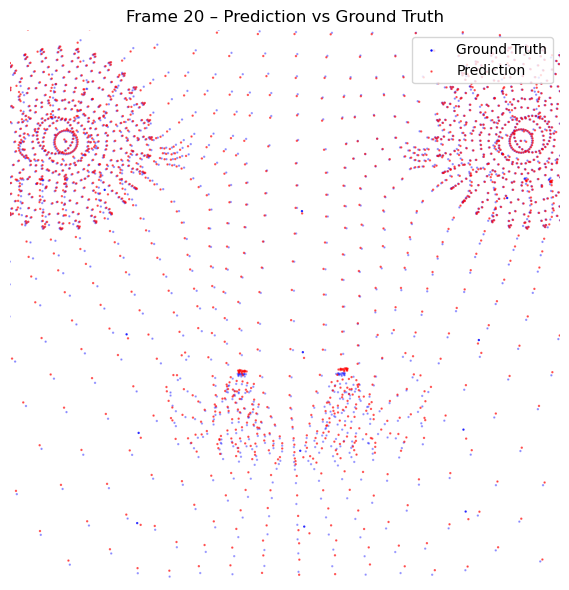

In [ ]:
# frame deformation over time
overlay_mesh_comparison(predicted_mesh, groundtruth_mesh, frame_idx=20)

In [ ]:
def plot_temporal_mse(pred_seq, gt_seq):
    num_frames = min(len(pred_seq), len(gt_seq))
    mse_per_frame = [
        np.mean((pred_seq[i] - gt_seq[i]) ** 2)
        for i in range(num_frames)
    ]

    plt.figure(figsize=(8, 4))
    plt.plot(mse_per_frame, color='orange', linewidth=2)
    plt.xlabel("Frame Index")
    plt.ylabel("Mean Squared Error")
    plt.title("Prediction vs Ground Truth Error Over Time")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


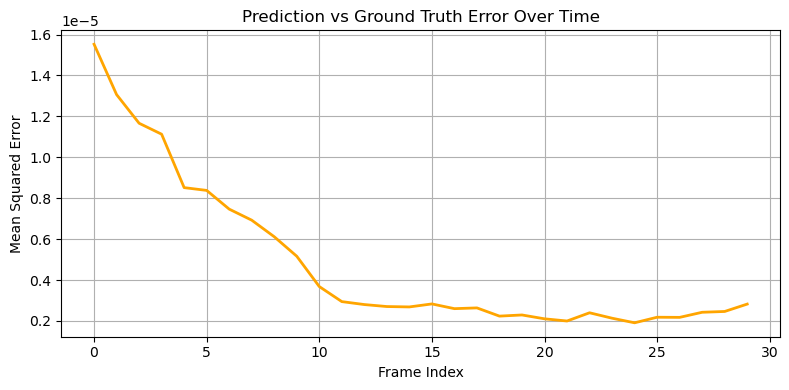

In [ ]:
plot_temporal_mse(predicted_mesh, groundtruth_mesh)

In [ ]:
# === Animate Predicted vs. Ground Truth 3D Mesh Side-by-Side ===

def animate(pred_seq, gt_seq, num_frames=None, interval=100, zoom=1, elev=-90, azim=90, size=0.3):
    import matplotlib.pyplot as plt
    from matplotlib import animation

    pred = np.stack(pred_seq) if isinstance(pred_seq, (list, tuple)) else pred_seq
    gt   = np.stack(gt_seq) if isinstance(gt_seq, (list, tuple)) else gt_seq

    total_frames = min(len(pred), len(gt))
    num_frames = min(num_frames or total_frames, total_frames)

    pred *= zoom
    gt *= zoom

    fig = plt.figure(figsize=(10, 5))
    ax_pred = fig.add_subplot(1, 2, 1, projection='3d')
    ax_gt   = fig.add_subplot(1, 2, 2, projection='3d')

    for ax, label in [(ax_pred, "Prediction"), (ax_gt, "Ground Truth")]:
        ax.set_title(label)
        ax.set_axis_off()
        ax.set_xlim([-0.1, 0.1])
        ax.set_ylim([-0.1, 0.1])
        ax.set_zlim([-0.1, 0.1])
        ax.view_init(elev=elev, azim=azim)

    scatter_pred = ax_pred.scatter([], [], [], s=size)
    scatter_gt   = ax_gt.scatter([], [], [], s=size)

    def update(frame_idx):
        scatter_pred._offsets3d = (pred[frame_idx][:, 0], pred[frame_idx][:, 1], pred[frame_idx][:, 2])
        scatter_gt._offsets3d   = (gt[frame_idx][:, 0], gt[frame_idx][:, 1], gt[frame_idx][:, 2])
        return scatter_pred, scatter_gt

    anim = animation.FuncAnimation(fig,update,frames=num_frames,interval=interval,blit=False)

    plt.close(fig)
    return anim


In [ ]:
# animate prediction vs ground truth 
anim = animate(predicted_mesh, groundtruth_mesh, interval=100, zoom=1, size=1)
HTML(anim.to_jshtml())
